In [44]:
import pyvista as pv
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from shapely import Polygon
from geopandas import GeoDataFrame


def create_non_overlapping_points(
    n_points, distance_thresh=1, size=10, random_seed=None
):
    np.random.seed(random_seed)
    all_points = (np.random.rand(1, 2) - 0.5) * size
    while all_points.shape[0] < n_points:
        new_point = (np.random.rand(1, 2) - 0.5) * size

        dist_from_existing = cdist(new_point, all_points)
        if np.min(dist_from_existing) > distance_thresh:
            all_points = np.concatenate((all_points, new_point), axis=0)

    return all_points


def extract_polygon(mesh: pv.PolyData):
    xy_points = mesh.points[:, :2]
    hull = ConvexHull(xy_points)
    return Polygon(xy_points[hull.vertices])

def make_color_gradient(color, number):
    repeated_colors = np.tile(color, (number, 1))
    brightness = np.expand_dims(np.linspace(0.5,1,number),1)
    scaled_colors = repeated_colors * brightness
    return scaled_colors

def create_scene_mesh(
    box_centers=(),
    cylinder_centers=(),
    cone_centers=(),
    cylinder_radius=0.5,
    cone_radius=0.5,
    box_size=1 / np.sqrt(2.0),
    grid_size=(20, 20),
    add_ground=True,
):
    box_meshes = []
    box_polygons = []
    ID = 0.0
    for x, y in box_centers:
        x_min = x - box_size / 2.0
        x_max = x + box_size / 2.0
        y_min = y - box_size / 2.0
        y_max = y + box_size / 2.0

        box = pv.Box((x_min, x_max, y_min, y_max, 0, box_size), quads=False)
        box["ID"] = np.full(box.n_cells, fill_value=ID)
        box_meshes.append(box)
        box_polygons.append(extract_polygon(box))
        ID += 1.0

    cylinder_meshes = []
    cylinder_polygons = []
    for x, y in cylinder_centers:
        cylinder = pv.Cylinder(
            (x, y, 0.5), direction=(0, 0, 1), radius=cylinder_radius, resolution=10
        ).triangulate()
        cylinder["ID"] = np.full(cylinder.n_cells, fill_value=ID)
        cylinder_meshes.append(cylinder)
        cylinder_polygons.append(extract_polygon(cylinder))
        ID += 1.0

    cone_meshes = []
    cone_polygons = []
    for x, y in cone_centers:
        cone = pv.Cone(
            (x, y, 0.5),
            direction=(0, 0, -1),
            radius=cone_radius,
            resolution=12,
        ).triangulate()
        cone["ID"] = np.full(cone.n_cells, fill_value=ID)
        cone_meshes.append(cone)
        cone_polygons.append(extract_polygon(cone))
        ID += 1.0

    merged_mesh = pv.merge(box_meshes + cylinder_meshes + cone_meshes)
    labels_gdf = GeoDataFrame(
        {
            "name": ["cube"] * len(box_meshes)
            + ["cylinder"] * len(cylinder_meshes)
            + ["cone"] * len(cone_meshes)
        }
        ,geometry=box_polygons + cylinder_polygons + cone_polygons
    )

    if add_ground:
        # Add the ground plane
        ground_points = merged_mesh.points[np.isclose(merged_mesh.points[:, 2], 0)]
        grid_size_x, grid_size_y = grid_size
        # Add the corner points of the ground plane
        corner_points = (
            np.array(
                [
                    [-grid_size_x, +grid_size_y, 0],
                    [+grid_size_x, +grid_size_y, 0],
                    [+grid_size_x, -grid_size_y, 0],
                    [-grid_size_x, -grid_size_y, 0],
                ]
            )
            / 2
        )
        ground_points = np.concatenate((corner_points, ground_points), axis=0)
        # Triangulate between all the vertices
        ground_surf = pv.PolyData(ground_points).delaunay_2d()
        # Set the ID to nan
        ground_surf["ID"] = np.full(ground_surf.n_cells, fill_value=np.nan)
        # Merge the ground plane with the other actors
        merged_mesh = merged_mesh + ground_surf
    return merged_mesh, labels_gdf



/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


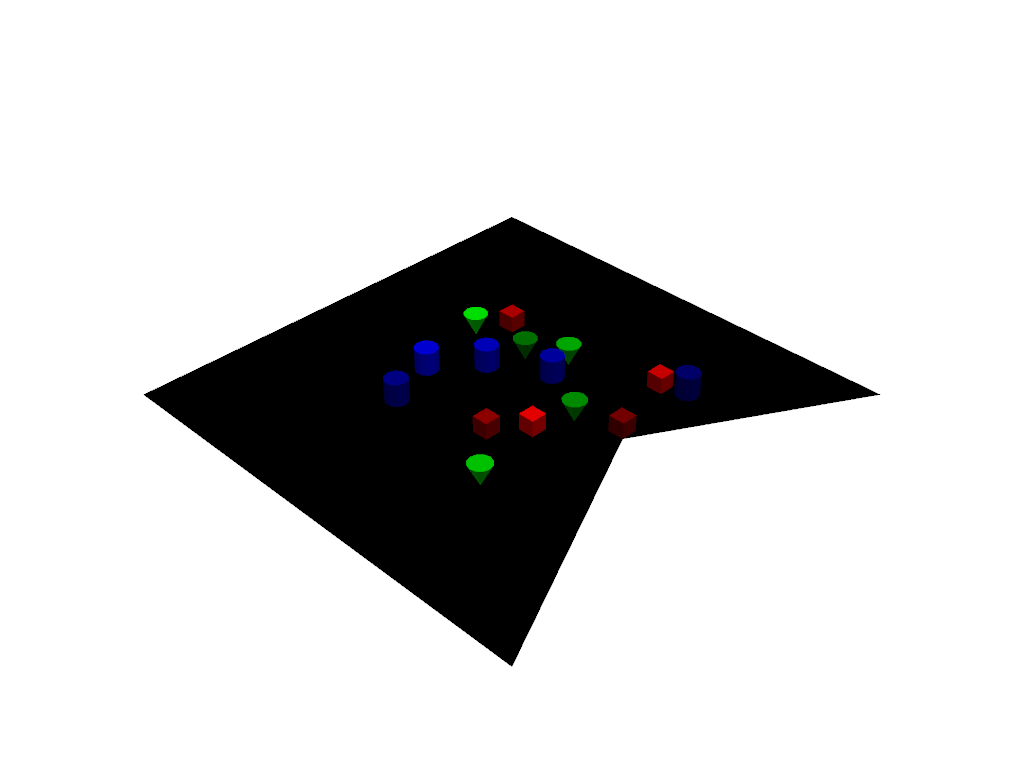

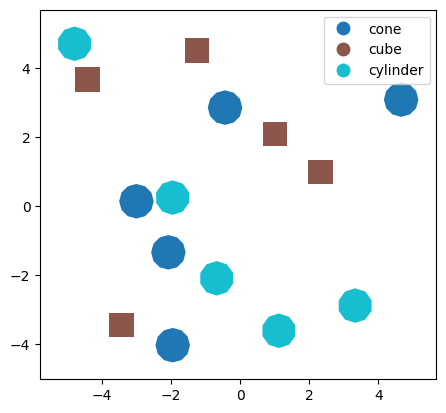

In [49]:

points = create_non_overlapping_points(n_points=15, random_seed=42)

mesh, labels_gdf = create_scene_mesh(
    box_centers=points[:5],
    cylinder_centers=points[5:10],
    cone_centers=points[10:],
    add_ground=True,
)
labels_gdf.plot("name", legend=True)
mesh["ID"]

color_dict = {"cube":(1,0,0), "cone":(0,1,0), "cylinder":(0,0,1)}

scalars = np.full((mesh.n_cells,3), fill_value=0.5)

for name, group in labels_gdf.groupby("name"):
    num = len(group)
    gradient = make_color_gradient(color_dict[name], num)
    # Indices into the original dataset
    IDs = group.index.to_numpy()
    # TODO rename
    for ID, color in zip(IDs, gradient):
        matching = mesh["ID"]==ID
        scalars[matching, :] = color 
    
plotter = pv.Plotter()
pv.start_xvfb()
plotter.add_mesh(mesh, scalars=scalars, rgb=True)
plotter.show()